# COURSE: A deep understanding of deep learning
## SECTION: More on data
### LECTURE: CodeChallenge: unbalanced data
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import and process the data

In [2]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# Create the three thresholds

In [3]:
threshold1 = 4.5
threshold2 = 5.5
threshold3 = 6.5

data_threshold1 = data.copy()
data_threshold1['boolQuality'] = 0
tmp = (data_threshold1['quality']>threshold1).astype(int)
data_threshold1['boolQuality'] =  tmp

data_threshold2 = data.copy()
data_threshold2['boolQuality'] = 0
tmp = (data_threshold2['quality']>threshold2).astype(int)
data_threshold2['boolQuality'] =  tmp

data_threshold3 = data.copy()
data_threshold3['boolQuality'] = 0
tmp = (data_threshold3['quality']>threshold3).astype(int)
data_threshold3['boolQuality'] =  tmp

# Re-organize the data: train/test in DataLoaders

In [4]:
# convert from pandas dataframe to tensor
dataT_threshold1  = torch.tensor( data_threshold1[cols2zscore].values ).float()
labelsT_threshold1 = torch.tensor( data_threshold1['boolQuality'].values ).float()
labelsT_threshold1 = labelsT_threshold1[:,None] # transform to matrix

dataT_threshold2  = torch.tensor( data_threshold2[cols2zscore].values ).float()
labelsT_threshold2 = torch.tensor( data_threshold2['boolQuality'].values ).float()
labelsT_threshold2 = labelsT_threshold2[:,None] # transform to matrix

dataT_threshold3  = torch.tensor( data_threshold3[cols2zscore].values ).float()
labelsT_threshold3 = torch.tensor( data_threshold3['boolQuality'].values ).float()
labelsT_threshold3 = labelsT_threshold3[:,None] # transform to matrix


In [5]:
# use scikitlearn to split the data
train_data1,test_data1, train_labels1,test_labels1 = train_test_split(dataT_threshold1, labelsT_threshold1, test_size=.1)
train_data2,test_data2, train_labels2,test_labels2 = train_test_split(dataT_threshold2, labelsT_threshold2, test_size=.1)
train_data3,test_data3, train_labels3,test_labels3 = train_test_split(dataT_threshold3, labelsT_threshold3, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data1 = torch.utils.data.TensorDataset(train_data1,train_labels1)
test_data1  = torch.utils.data.TensorDataset(test_data1,test_labels1)
train_data2 = torch.utils.data.TensorDataset(train_data2,train_labels2)
test_data2  = torch.utils.data.TensorDataset(test_data2,test_labels2)
train_data3 = torch.utils.data.TensorDataset(train_data3,train_labels3)
test_data3  = torch.utils.data.TensorDataset(test_data3,test_labels3)

# finally, translate into dataloader objects
batchsize    = 64
train_loader1 = DataLoader(train_data1,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader1  = DataLoader(test_data1,batch_size=test_data1.tensors[0].shape[0])
train_loader2 = DataLoader(train_data2,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader2  = DataLoader(test_data2,batch_size=test_data2.tensors[0].shape[0])
train_loader3 = DataLoader(train_data3,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader3  = DataLoader(test_data3,batch_size=test_data3.tensors[0].shape[0])

# Now for the DL part

In [6]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self,actfun):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)

    # activation funcion to pass through
    self.actfun = actfun
  
  # forward pass
  def forward(self,x):
    # get activation function type
    # this code replaces torch.relu with torch.<self.actfun>
    actfun = getattr(torch.nn,self.actfun)
    x = actfun()( self.input(x) )
    x = actfun()( self.fc1(x) )
    x = actfun()( self.fc2(x) )
    return self.output(x)

# Train the model

In [7]:
# a function that trains the model

# global parameter
numepochs = 500

def trainTheModel(model,train_loader,test_loader):

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=.001)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []
  test0Acc = []
  test1Acc = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    model.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = model(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    model.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = model(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

    # test accuracy for each class
    test0Acc.append( 100*torch.mean(((yHat>0) == y)[y==0].float()).item() )
    test1Acc.append( 100*torch.mean(((yHat>0) == y)[y==1].float()).item() )
  
  # function output
  return trainAcc,testAcc,test0Acc,test1Acc,losses

In [8]:
# test the training
winenet0 = ANNwine('ReLU')
trainAcc,testAcc,test0Acc,test1Acc,losses = trainTheModel(winenet0,train_loader1,test_loader1)
print(f"Final accuracy: {testAcc[-1]:.2f}%")

Final accuracy: 97.50%


In [9]:
trainByThr = np.zeros((numepochs,3)) # 3 different data thresholds
testByThr  = np.zeros((numepochs,3))
test0ByThr = np.zeros((numepochs,3))
test1ByThr = np.zeros((numepochs,3))
lossesByThr = np.zeros((numepochs,3))

# create a model and train it
winenet1 = ANNwine('LeakyReLU')
trainByThr[:,0],testByThr[:,0],test0ByThr[:,0],test1ByThr[:,0],lossesByThr[:,0] = trainTheModel(winenet1, train_loader1, test_loader1)

winenet2 = ANNwine('LeakyReLU')
trainByThr[:,1],testByThr[:,1],test0ByThr[:,1],test1ByThr[:,1],lossesByThr[:,1] = trainTheModel(winenet2, train_loader2, test_loader2)

winenet3 = ANNwine('LeakyReLU')
trainByThr[:,2],testByThr[:,2],test0ByThr[:,2],test1ByThr[:,2],lossesByThr[:,2] = trainTheModel(winenet3, train_loader3, test_loader3)


/tmp/ipykernel_2130467/227824671.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  trainByThr[:,0],testByThr[:,0],test0ByThr[:,0],test1ByThr[:,0],lossesByThr[:,0] = trainTheModel(winenet1, train_loader1, test_loader1)
/tmp/ipykernel_2130467/227824671.py:12: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  trainByThr[:,1],testByThr[:,1],test0ByThr[:,1],test1ByThr[:,1],lossesByThr[:,1] = trainTheModel(winenet2, train_loader2, test_loader2)
/tmp/ipykernel_2130467/227824671.py:15: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  trainByThr[:,2],testByThr[:,2],test0ByThr[:,2],test1ByThr[:,2],lossesByThr[:,2] = trainTheModel(wi

In [10]:

sumBad0 = sum(data_threshold1['boolQuality']==0)
sumGood0 = sum(data_threshold1['boolQuality']==1)

sumBad1 = sum(data_threshold2['boolQuality']==0)
sumGood1 = sum(data_threshold2['boolQuality']==1)

sumBad2 = sum(data_threshold3['boolQuality']==0)
sumGood2 = sum(data_threshold3['boolQuality']==1)

# Plot the results

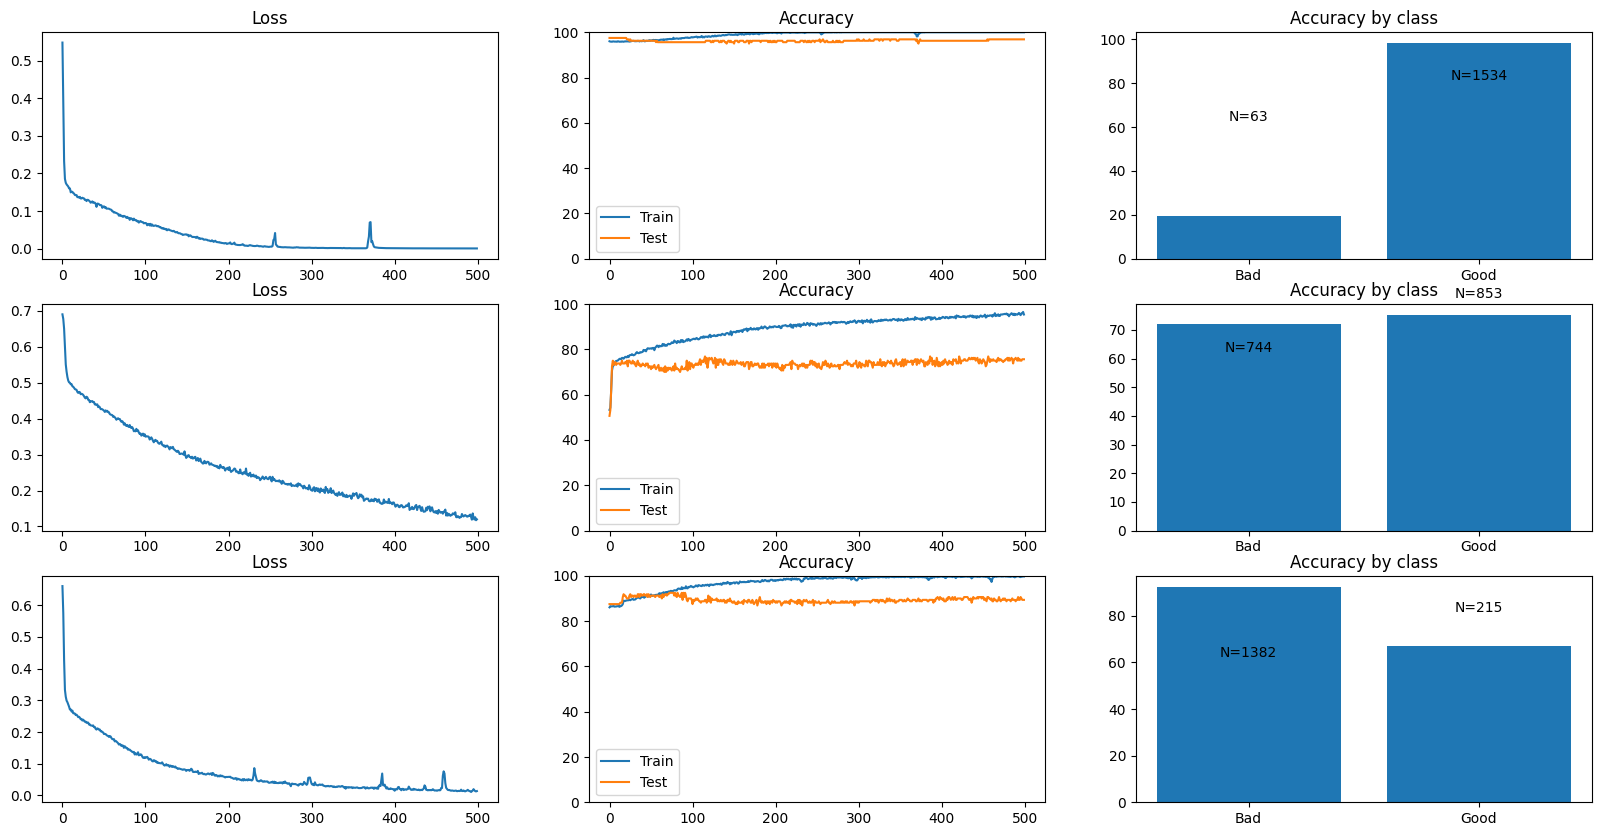

In [22]:
fig,ax = plt.subplots(3,3,figsize=(20,10))

for i in range (3):
  ax[i,0].plot(lossesByThr[:,i])
  ax[i,0].set_title('Loss')
  ax[i,1].plot(trainByThr[:,i])
  ax[i,1].plot(testByThr[:,i])
  ax[i,1].set_title('Accuracy')
  ax[i,1].legend(['Train','Test'])
  ax[i,1].set_ylim([0,100])
  ax[i, 2].bar(['Bad', 'Good'], [test0ByThr[:, i].mean(), test1ByThr[:, i].mean()])
  ax[i,2].set_title('Accuracy by class')

ax[0,2].text(0, test0ByThr.mean(), f'N={sumBad0}', ha='center', va='bottom')
ax[0,2].text(1, test1ByThr.mean(), f'N={sumGood0}', ha='center', va='bottom')
ax[1,2].text(0, test0ByThr.mean(), f'N={sumBad1}', ha='center', va='bottom')
ax[1,2].text(1, test1ByThr.mean(), f'N={sumGood1}', ha='center', va='bottom')
ax[2,2].text(0, test0ByThr.mean(), f'N={sumBad2}', ha='center', va='bottom')
ax[2,2].text(1, test1ByThr.mean(), f'N={sumGood2}', ha='center', va='bottom')






plt.show()